# <Center> HW 4: Classification </center>

**Instructions**: 
- Please read the problem description carefully
- Make sure to complete all requirements (shown as bullets) . In general, it would be much easier if you complete the requirements in the order as shown in the problem description
- Please submit a py, a pdf file, and your jupyter notebook (optional).
- Code of academic integrity:
    - **Each assignment needs to be completed independently. This is NOT group assignment**. 
    - Never ever copy others' work (even with minor modification, e.g. changing variable names)
    - If you generate code using large lanaguage models (although it is not encouraged), make sure to adapt the generated code to meet all requirements and it is executable.
    - Anti-Plagiarism software will be used to check similarities between all submissions.
    - Check Syllabus for more details.

In this assignment, we use classification to identify deceptive comments. This assignment needs the following two data files:
- hw4_train.csv: dataset for training
- hw4_test.csv: dataset for testing
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  when i first checked the hotel's website and r...|
|1|  I had really high hopes for this hotel. The lo...|
|0|  My experiences at the Fairmont Chicago were le...|
|...|...|


In [41]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

pd.options.display.float_format = "{:,.4f}".format
InteractiveShell.ast_node_interactivity = "all"

# fix seeds to ensure reproducibility of results
np.random.seed(2024) 

# add your import statements
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [42]:
train = pd.read_csv("hw4_train.csv")
train.head(3)
test = pd.read_csv("hw4_test.csv")
test.head(3)

,label,text
0,1,when i first checked the hotel's website and r...
1,1,I had really high hopes for this hotel. The lo...
2,1,Hotel Monaco is simply amazing. I travel quite...


,label,text
0,1,This is the hotel for the discriminating busin...
1,0,"What a wonderful experience, super great, help..."
2,0,I stayed at the Talbott twice in the last few ...


## Q1 Text Vectorization and Naive Bayes (5 points)


For classification, the first step is to compute the word TF-IDF weights for each document. A few options can be configured as given below.


Define a function `classify(train_docs, train_y, test_docs, test_y, binary=False, use_idf=True, stop_words=None, max_features=None, show_plots=False)`, where


- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
- `test_docs`: is a list of documents for test.
- `test_y`: is the ground-truth labels of test documents.
- `classifier`: the name of classification algorithm. Two possible values: 'svm','naive bayes'. The default value is 'naive bayes'.
- `binary`: if true, within a document, the term frequency of a word is binarized to 1 if present and 0 otherwise. If False, the regular term frequency is considered. The default is False.
- `ngrams`: an option to include unigrams, bigrams, ..., nth grams. The default is (1,1), i.e., only unigrams used.
- `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
- `max_features`: the maximum number of features to be used. The default value is None, indicating all features are used.
- `show_plots`: controls whether to show classification report AND plots. The default is False.


This function does the following:
- Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, max_features, ngrams, binary` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
- Train a classifier by the specified `classifier` algorithm using the extracted features from `train_docs` and labels from `train_y`.
- Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
- Predict the labels for `test_docs` with trained model.
- If `show_plots` is True,
    - Print the classification report.
    - Plot the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. On the plot, specify xlabel, ylabel on axis, and the scoring metrics (AUC/PRC/Average Precision) on the title.
    - Note, if the classifier is 'svm', you may use `decision_function` instead of predict_proba function. The details can be found at https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function.
- Return the `TfidfVectorizer` and the trained model.
    

Test your function with following cases:
- `stop_words = 'english', max_features = 5000, binary = False, classifier='naive bayes', show_plots = True`
- `stop_words = 'english', max_features = 5000, binary = False, classifier='svm', show_plots = True`

In [44]:

def classify(train_docs, train_y, test_docs, test_y, \
                classifier = 'naive bayes',
                binary=False, ngrams = (1,1), \
                stop_words='english', max_features=None, \
                show_plots=True):
    
    clf, tfidf_vect = None, None
    #Fit a TfidfVectorizer using train_docs with options stop_words, max_features, ngrams, binary as specified in the function inputs. 
    #Extract features from train_docs using the fitted TfidfVectorizer.
    tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_features=max_features, ngram_range=ngrams, binary=binary)
    X_train_tfidf = tfidf_vect.fit_transform(train_docs)
    
    #Train a classifier by the specified classifier algorithm using the extracted features from train_docs and labels from train_y.
    if classifier == 'naive bayes':
        clf = MultinomialNB()
    elif classifier == 'svm':
        clf = svm.LinearSVC(dual=False)
    clf.fit(X_train_tfidf, train_y)

    #Transform test_docs by the fitted TfidfVectorizer (hint: use function transform not fit_transform).
    X_test_tfidf = tfidf_vect.transform(test_docs)
    
    # Predict the labels for the test data
    y_pred = clf.predict(X_test_tfidf)
    if classifier == 'svm':
        y_score = clf.decision_function(X_test_tfidf)
    else: 
        y_score = clf.predict_proba(X_test_tfidf)[:, 1] 
    
    #If show_plots is True,print the classification report.
    from sklearn.metrics import classification_report
    if show_plots:
        print(classification_report(test_y, y_pred))
    
    #Plot the AUC
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    if show_plots and classifier != 'svm':
        fpr, tpr, _ = roc_curve(test_y, y_score)
        roc_auc = auc(fpr, tpr)
    
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    #Plot the PRC
    from sklearn.metrics import precision_recall_curve, average_precision_score
    if show_plots:
        precision, recall, _ = precision_recall_curve(test_y, y_score)
        average_precision = average_precision_score(test_y, y_score)

        plt.figure()
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.show()
    
    
    return  clf, tfidf_vect

              precision    recall  f1-score   support

       legit       0.88      0.82      0.85       233
        fake       0.84      0.89      0.86       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



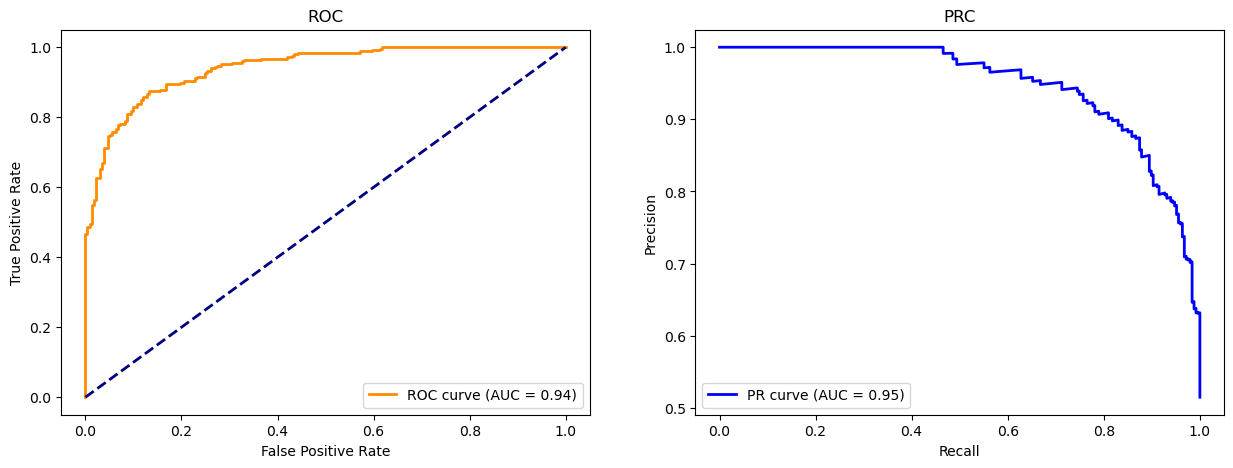

In [81]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           stop_words = 'english', binary = False, 
                           max_features = 5000,
                           classifier='naive bayes', show_plots = True)

/Users/shellyhsu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

       legit       0.87      0.85      0.86       233
        fake       0.86      0.88      0.87       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



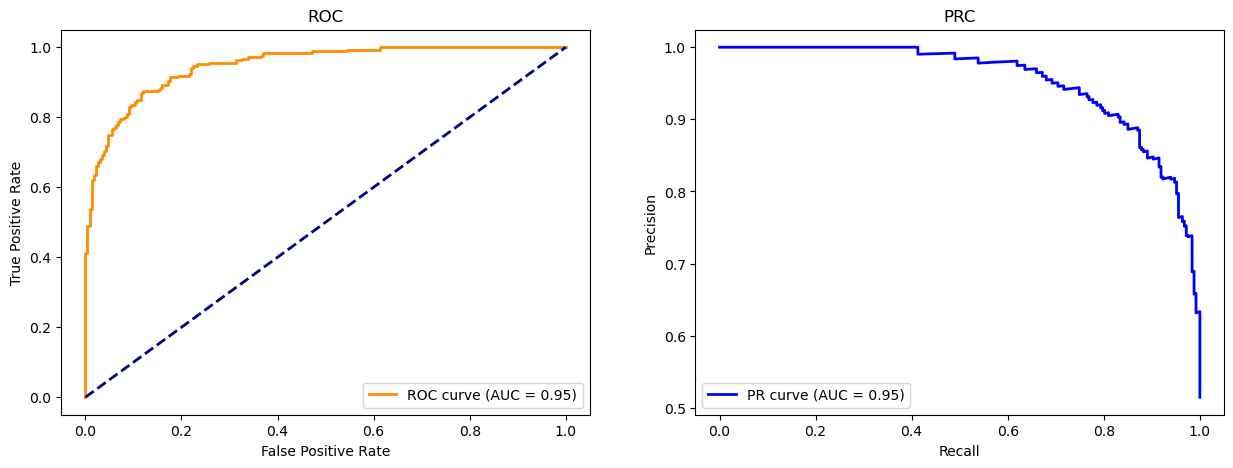

In [82]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           max_features = 5000,
                           stop_words = 'english', binary = False, 
                           classifier='svm', show_plots = True)

### Q2: Search for best parameters (2 points)


From Q1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters.

- Define a function `search_para(docs, y, classifier = 'naive bayes')` where `docs` are training documents, `y` is the ground-truth labels, and `classifier` is the model you use.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and the classifier as specified by parameter `classifier` . 
    - Define the parameter ranges as follow: 
        - `stop_words: [None, 'english']`
        - `max_features:[None, 5000]`
        - `ngram_range:[(1,1), (1,2)]`
        - `binary: [True, False]`
    - Set the scoring metric to `f1_macro`. 
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the values of the `best` parameters combination. 
    
- Call this function to find `the best parameters combination` for linear SVM and Naive Bayes models. 
- Call the function `classify` again to use `the best parameters combination`


Please briefly answer the following: 
- Compared with the model in Q1, how is the performance improved on the test dataset?
- Why do you think the new parameter values help deceptive comment classification?

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

def search_para(docs, y, classifier = 'naive bayes'):
    
    if classifier == 'naive bayes':
        clf = MultinomialNB()
    elif classifier == 'svm':
        clf = svm.LinearSVC(dual=False)  
    else:
        raise ValueError("Unsupported classifier: Choose either 'naive bayes' or 'svm'")

    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', clf)])

    parameters = {'tfidf__stop_words': [None, 'english'],
                  'tfidf__max_features': [None, 5000],
                  'tfidf__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__binary': [True, False],}
    
    scorer = make_scorer(f1_score, average='macro')
    
    grid_search = GridSearchCV(pipeline, parameters, scoring=scorer, cv=5, n_jobs=-1)
    
    grid_search.fit(docs, y)
    
    print("Best parameters set found on training set:")
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {grid_search.best_params_[param_name]}")
    
    print(f"best f1 score: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_

In [51]:
search_para(train["text"], train["label"])

Best parameters set found on training set:
	tfidf__binary: True
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
	tfidf__stop_words: None
best f1 score: 0.891


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, max_features=5000,
                                 ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [52]:
search_para(train["text"], train["label"], classifier ='svm')

Best parameters set found on training set:
	tfidf__binary: True
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__stop_words: None
best f1 score: 0.900


Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True, ngram_range=(1, 2))),
                ('clf', LinearSVC(dual=False))])

              precision    recall  f1-score   support

       legit       0.89      0.86      0.87       233
        fake       0.87      0.89      0.88       247

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480



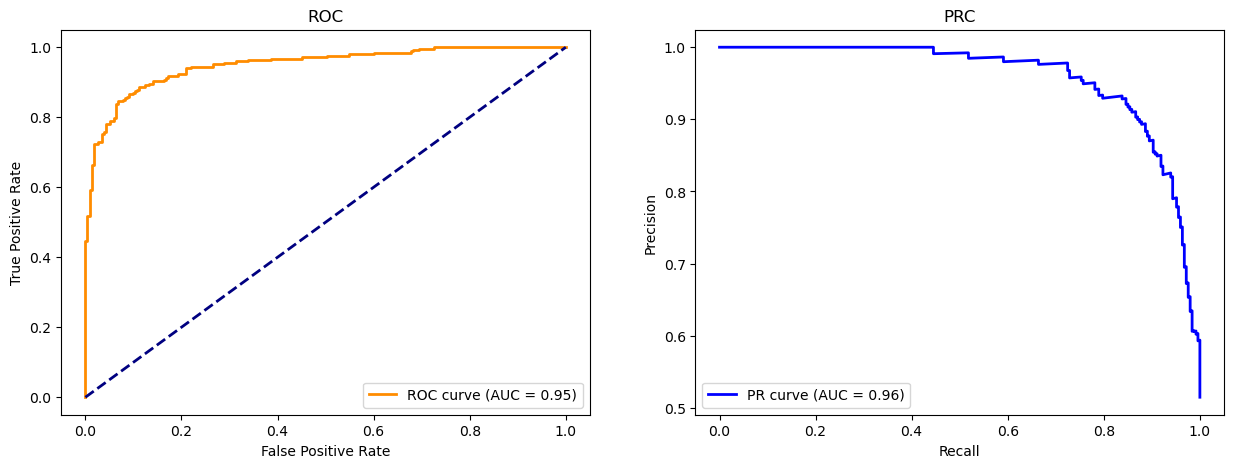

In [79]:
# retrain the model with the best parameter values you found
# You may get different parameter values

clf_nb, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, max_features = 5000, 
                              binary=True, ngrams = (1,2), 
                              classifier = 'naive bayes', show_plots=True)

/Users/shellyhsu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

       legit       0.90      0.85      0.87       233
        fake       0.87      0.91      0.89       247

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480



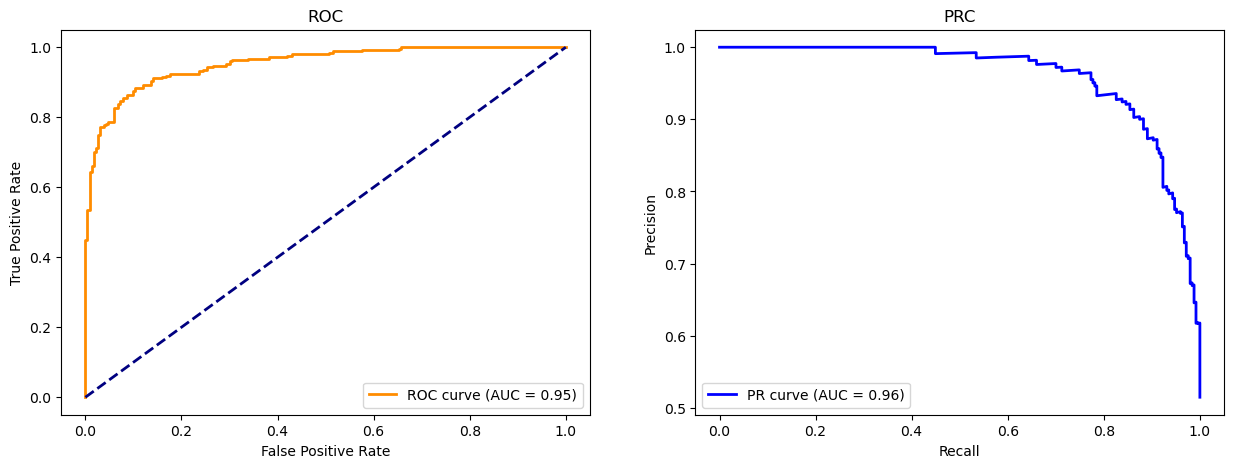

In [80]:
# retrain the model with the best parameter values you found
# You may get different parameter values

clf_svm, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, 
                              max_features = None, 
                              binary=True,
                              ngrams = (1,2), 
                              classifier = 'svm', show_plots=True)

1. Compared with the model in Q1, how is the performance improved on the test dataset?

- The adjustments in ngram_range, binary, max_features, and stop_words settings directly impact how text is vectorized, potentially capturing more relevant features or reducing noise in the feature set.
- The best parameters likely help the model generalize better to unseen data by optimizing how text data is processed and represented before classification.

2. Why do you think the new parameter values help deceptive comment classification?

- Setting binary to True in TfidfVectorizer means that the text data is vectorized in a way where the presence or absence of a word is more important than its frequency across documents. This can help in focusing on the existence of certain deceptive cues or phrases that are strong indicators of deception, regardless of their frequency.
- Using a limited number of features (e.g., 5000) can help in reducing overfitting by focusing the model on the most relevant terms and avoiding overly complex models that memorize training data specifics.
- Expanding the n-gram range to include bigrams (1, 2) allows the model to consider pairs of words in addition to individual words. This can capture contextual nuances and combinations of words that are more predictive of deceptive content than single words alone.
- Removing stop words can sometimes remove useful context, so keeping them (None) might have proved beneficial in retaining valuable linguistic details necessary for detecting subtleties in deceptive statements.

## Q3. Impact of Sample Size (3 points)

This task is to help you understand the impact of sample size on classifier performance. 

Define a function `show_sample_size_impact(train_docs, train_y, classifier = 'naive bayes')` where:
- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
    
Conduct the experiment as follows:    
- Starting with 100 samples, in each round you build a classifier with 100 more samples. i.e. in round 1, you use samples from 0 to 100, and in round 2, you use samples from 0 to 200, …, until you use all samples. 
- In each round, you'll conduct `4-fold cross validation` as follows:
    - Train both Naive Bayes and Linear SVM models
    - Set the TFIDF vectorizer to remove English stopwords, set ngram range to (1,2), and set max_features to 5000.
    - Record the average testing F1-macro score.
    
    
- Plot a line chart to show the relationship between sample size and the F1-macro score for SVM and Naive Bayes models. 
- This function has no return.
    
    
- Write your analysis on the following:
    - How does sample size affect each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
  

In [86]:
def show_sample_size_impact(train_docs, train_y):
    # Initialize the results lists for storing the F1-macro scores
    results_nb = []
    results_svm = []
    sample_sizes = range(100, len(train_docs) + 1, 100)

    for size in sample_sizes:
        # Subset the training data and labels to the current size
        subset_docs = train_docs[:size]
        subset_labels = train_y[:size]

        # Define the cross-validation strategy with a consistent random state
        cv_strategy = KFold(n_splits=4, shuffle=True, random_state=42)

        # Define the pipeline for the Naive Bayes classifier with consistent hyperparameters
        pipeline_nb = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)),
            ('clf', MultinomialNB()),
        ])

        # Define the pipeline for the SVM classifier with consistent hyperparameters
        pipeline_svm = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)),
            ('clf', LinearSVC(dual=False, random_state=42)),
        ])

        # Calculate the F1-macro scores across 4 folds for Naive Bayes
        f1_scores_nb = cross_val_score(pipeline_nb, subset_docs, subset_labels, cv=cv_strategy,
                                       scoring=make_scorer(f1_score, average='macro'))
        results_nb.append(np.mean(f1_scores_nb))

        # Calculate the F1-macro scores across 4 folds for SVM
        f1_scores_svm = cross_val_score(pipeline_svm, subset_docs, subset_labels, cv=cv_strategy,
                                        scoring=make_scorer(f1_score, average='macro'))
        results_svm.append(np.mean(f1_scores_svm))

    # Plotting the F1-macro scores for Naive Bayes and SVM
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, results_nb, label='Naive Bayes')
    plt.plot(sample_sizes, results_svm, label='SVM')
    plt.xlabel('Size')
    plt.legend()
    plt.show()


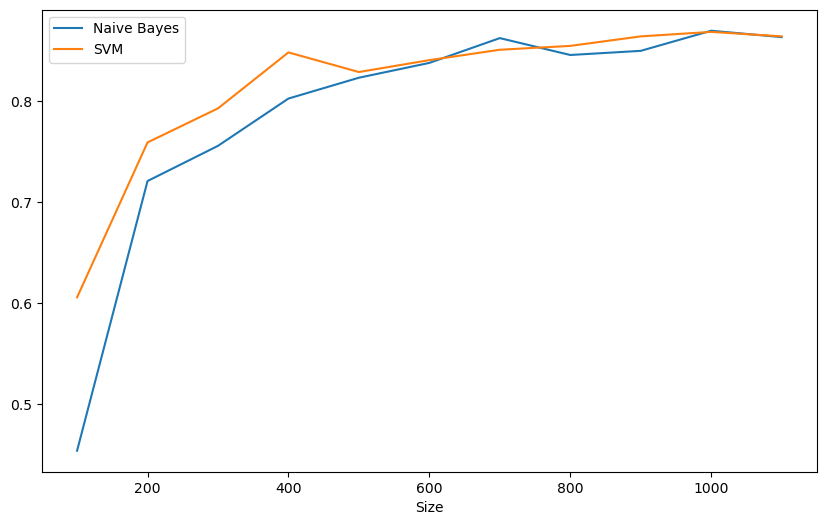

In [64]:
show_sample_size_impact(train["text"], train["label"])

1. How does sample size affect each classifier’s performance? 
- With more examples to learn from, the models can capture a more accurate representation of the underlying patterns in the data, which helps to improve their predictions.
- A larger dataset can help reduce overfitting, where a model performs well on training data but poorly on unseen data. With more samples, the model is less likely to learn noise and more likely to generalize.
- Initially, the performance increase can be quite steep as the sample size grows, but after a certain point, the performance gain tends to level off. This is visible in the graph, where both curves plateau, indicating that adding more data beyond a certain point yields minimal performance benefits.
- Different classifiers may benefit differently from additional data. In the provided graph, SVM seems to plateau sooner than Naive Bayes, suggesting it may require fewer samples to reach optimal performance.

2. If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
- Estimate the cost of acquiring and labeling additional samples and the benefit of improved model performance. The "benefit" could be measured in terms of the value the improved accuracy brings to your application.
- Determine a performance threshold that meets your application's minimum requirements. Once a classifier reaches this threshold, additional samples may not be worth the cost.
- Look for the point on the graph where the performance curve begins to plateau. Increasing the sample size beyond this point yields diminishing returns.

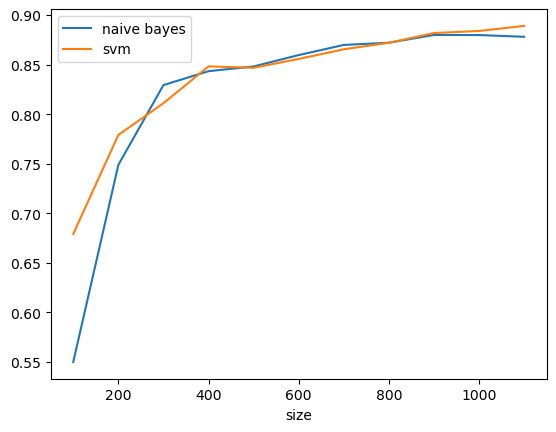

In [64]:
show_sample_size_impact(train["text"], train["label"])

## Q4 (Bonus): Model Interpretation (2 points)


For this dataset, both Naive Bayes and SVM model can provide good classification accuracy. How does the models conclude that a document is deceptive? What features have the discriminative power?


Let's consider the models you trained in Q2 with the best parameter values. Two test documents have been provided below. The ground truth of the first document is 0 and the second one is 1. For each document, can you show the following:

1. What are the top-10 most important features used by each classifier to produce the predictionS? 
1. Do the two models agree on the most important features?
1. Based on the intepretation, which model do you trust more? 


Implement an explanation model here and answer questions 1-3.

In [56]:
docs = ['''We visited for my 40th birthday. We had never been to Chicago so was not sure where to stay. 
           Found the deal on this hotel from Travelzoo.
           Great rate, staff was awesome, very helpful and nice, location was great. 
           Enjoyed our stay but still like NYC better. Great, great hotel. Would stay again.''',
        '''My experience at the Hyatt Regency Chicago was simply amazing. 
           I had a wonderful stay there will my husband. 
           My husband has allergy problems nearly everywhere we go, and we were worried about that so we talked to the desk clerk there. 
           They were able to provide us with a Hyatt allergy-friendly room. 
           We were so relieved and the room was beautiful. 
           The furniture in the room was actually cleaned with pure tea tree oil. 
           It was the most comfortable stay we have ever had. 
           On top of that my husband had to spend some time in the room working on some business, 
           so the high speed internet they provided was very convenient. 
           We took full advantage of the 24 hour room service. 
           I will definitely stay there again. It is a vacation simply staying in your hotel room.''']

labels = [0, 1]

In [87]:
# retrain the model with the best parameter values you found
# You may get different parameter values

clf_svm, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, 
                              max_features = 5000, 
                              binary=True,
                              ngrams = (1,2), 
                              classifier = 'svm', show_plots=False)

/Users/shellyhsu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [88]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

def explain_model(train_docs, labels, clf_nb, clf_svm, vectorizer):
    X_test = vectorizer.transform(train_docs)

    
    # Top features for Naive Bayes
    nb_feature_importances = clf_nb.feature_log_prob_[1]  # Assuming '1' is the positive class
    nb_top_features_idx = np.argsort(nb_feature_importances)[-10:]
    nb_top_features = feature_names[nb_top_features_idx]
    print("Top-10 features for Naive Bayes:", nb_top_features)
    
    # Top features for SVM
    svm_feature_importances = clf_svm.coef_[0]
    svm_top_features_idx = np.argsort(svm_feature_importances)[-10:]
    svm_top_features = feature_names[svm_top_features_idx]
    print("Top-10 features for SVM:", svm_top_features)
    
    # Compare features between the two models
    common_features = set(nb_top_features) & set(svm_top_features)
    print("Common features:", common_features)
    
    # Trustworthiness
    if common_features:
        print("Both models agree on some important features, this may indicate more trust in predictions.")
    else:
        print("The models disagree on the important features, so the trustworthiness may depend on domain knowledge.")
    
    # Prediction and interpretation for the test documents
    for i, doc in enumerate(train_docs):
        print(f"\nDocument {i+1} prediction:")
        print("Naive Bayes:", "Deceptive" if clf_nb.predict(X_test[i]) else "Truthful")
        print("SVM:", "Deceptive" if clf_svm.predict(X_test[i]) else "Truthful")


explain_model(docs, labels, clf_nb, clf_svm, vectorizer)


Top-10 features for Naive Bayes: ['apologize finally' 'ahead hotel' 'bad didn' '24 stay' 'ave head'
 'atention' 'affordable vacation' '14 wans' 'angry' '676 restaurant']
Top-10 features for SVM: ['arrived room' 'ago showed' 'awesome location' 'attend air'
 'anniversary pleasantly' 'bar previous' 'angry' '6pm obviously'
 'amazingly competent' '676 restaurant']
Common features: {'676 restaurant', 'angry'}
Both models agree on some important features, this may indicate more trust in predictions.

Document 1 prediction:
Naive Bayes: Truthful
SVM: Truthful

Document 2 prediction:
Naive Bayes: Deceptive
SVM: Deceptive
